## 1. Setup & Configuration

In [1]:
import yaml
import os
import sys
import json
import tempfile

# Windows compatibility
if sys.platform == "win32":
    import socketserver
    if not hasattr(socketserver, 'UnixStreamServer'):
        socketserver.UnixStreamServer = socketserver.TCPServer

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, count, countDistinct, desc, lit, avg, row_number,
    radians, sin, cos, sqrt, atan2, max as spark_max, min as spark_min,
    explode, array, struct, udf, broadcast
)
from pyspark.sql.types import (
    StructType, StructField, StringType, FloatType, ArrayType, DoubleType
)
from pyspark.sql.window import Window

# Load configuration
with open("../../config/config.yml") as f:
    config = yaml.safe_load(f)

# NOUVEAU: Buffer réduit pour l'approche full path
BUFFER_M = 50  # Au lieu de 200m avec les centroïdes

silver_dir = config["paths"]["silver_dir"]
gold_dir = config["paths"]["gold_dir"]

print(f"✓ Buffer distance: {BUFFER_M}m (full path approach)")
print(f"✓ Silver data: {silver_dir}")
print(f"✓ Gold output: {gold_dir}")

✓ Buffer distance: 50m (full path approach)
✓ Silver data: data/silver
✓ Gold output: data/gold


In [2]:
# Initialize Spark session
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
local_temp = tempfile.gettempdir()

spark = SparkSession.builder \
    .appName("Module2_SpatialUsage_FullPath") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.ui.enabled", "false") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.local.dir", local_temp) \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"✓ Spark version: {spark.version}")

✓ Spark version: 3.5.3


## 2. Load Silver Data

In [3]:
silver_path = f"../../{silver_dir}"

# Charger la table avec les coordonnées complètes
df_amenagements = spark.read.parquet(f"{silver_path}/silver_amenagements_with_coordinates")
df_sites = spark.read.parquet(f"{silver_path}/silver_sites")
df_channels = spark.read.parquet(f"{silver_path}/silver_channels")

# Charger les mesures
try:
    df_measures = spark.read.parquet(f"{silver_path}/silver_measures_union2")
    measures_source = "silver_measures_union2"
except:
    try:
        df_measures = spark.read.parquet(f"{silver_path}/silver_measures_union")
        measures_source = "silver_measures_union"
    except:
        df_measures = spark.read.parquet(f"{silver_path}/silver_measures")
        measures_source = "silver_measures"

print("✓ Loaded Silver Parquet files:")
print(f"  - silver_amenagements_with_coordinates: {df_amenagements.count()} rows")
print(f"  - silver_sites: {df_sites.count()} rows")
print(f"  - silver_channels: {df_channels.count()} rows")
print(f"  - {measures_source}: {df_measures.count()} rows")

✓ Loaded Silver Parquet files:
  - silver_amenagements_with_coordinates: 4592 rows
  - silver_sites: 280 rows
  - silver_channels: 1302 rows
  - silver_measures_union2: 485651 rows


In [4]:
# Vérifier la structure des données
print("=== Amenagements avec coordonnées ===")
df_amenagements.printSchema()

# Vérifier qu'on a bien la colonne coordiantes
assert 'coordiantes' in df_amenagements.columns, "ERREUR: colonne 'coordiantes' manquante!"
print("✓ Colonne 'coordiantes' présente")

# Aperçu
df_amenagements.select("amenagement_id", "nom", "coordiantes").show(3, truncate=50)

=== Amenagements avec coordonnées ===
root
 |-- amenagement_id: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- commune1: string (nullable = true)
 |-- insee1: string (nullable = true)
 |-- commune2: string (nullable = true)
 |-- insee2: string (nullable = true)
 |-- reseau: string (nullable = true)
 |-- financementac: string (nullable = true)
 |-- typeamenagement: string (nullable = true)
 |-- typeamenagement2: string (nullable = true)
 |-- positionnement: string (nullable = true)
 |-- senscirculation: string (nullable = true)
 |-- environnement: string (nullable = true)
 |-- localisation: string (nullable = true)
 |-- typologiepiste: string (nullable = true)
 |-- revetementpiste: string (nullable = true)
 |-- domanialite: string (nullable = true)
 |-- reglementation: string (nullable = true)
 |-- zonecirculationapaisee: string (nullable = true)
 |-- anneelivraison: double (nullable = true)
 |-- longueur_m: double (nullable = true)
 |-- observation: string (nullable =

In [5]:
print("=== Sites ===")
df_sites.show(5)

print("\n=== Channels ===")
df_channels.show(5)

=== Sites ===
+--------------+--------------------+------------------+-----------------+----------+-------------------+--------------+
|       site_id|           site_name|               lon|              lat|insee_code|infrastructure_type|parent_site_id|
+--------------+--------------------+------------------+-----------------+----------+-------------------+--------------+
|69149.00072.12|OULLINS_Gare rout...|        4.81512527|       45.7168309|     69600|OTHER SPECIFIC SITE|69149.00072.12|
|69194.00013.02|SAINT DIDIER_59 A...|       4.798341188|      45.81053311|     69370|OTHER SPECIFIC SITE|69194.00013.02|
|     100017792|Vaulx en Velin_Po...|4.9357686189513625|45.77073817594027|     69256|               NULL|          NULL|
|     100017793|Décines_Passerell...| 4.954341799020768|45.77486440927123|     69275|               NULL|          NULL|
|     100024515|Villeurbanne_Pont...|           4.89176|         45.78389|     69266|               NULL|          NULL|
+--------------+--

In [29]:
print("=== Measures ===")
df_measures.printSchema()
df_measures.show()
df_measures.dtypes

=== Measures ===
root
 |-- point_id: string (nullable = true)
 |-- point_type: string (nullable = true)
 |-- flux: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- direction: string (nullable = true)
 |-- vehicule_type: string (nullable = true)
 |-- date: date (nullable = true)

+---------+----------+----+------------------+------------------+---------+-------------+----------+
| point_id|point_type|flux|               lat|               lon|direction|vehicule_type|      date|
+---------+----------+----+------------------+------------------+---------+-------------+----------+
|100031128|      auto| 726|          45.72373|          4.893222|     NULL|         NULL|2023-02-06|
|100030258|      auto|3763|45.743805467619744|4.8410793877663005|     NULL|         NULL|2023-02-06|
|100031124|      auto| 793|          45.75127|           4.82288|     NULL|         NULL|2023-02-06|
|100047690|      auto|4704| 45.75707455320546| 4.8597705420266

[('point_id', 'string'),
 ('point_type', 'string'),
 ('flux', 'int'),
 ('lat', 'double'),
 ('lon', 'double'),
 ('direction', 'string'),
 ('vehicule_type', 'string'),
 ('date', 'date')]

## 3. Nouvelle approche: Distance minimale au tracé complet

**Stratégie d'optimisation:**
1. Parser les coordonnées JSON et calculer la bounding box de chaque aménagement
2. Pré-filtrer les paires (aménagement, site) par bounding box + marge
3. Pour les paires candidates, calculer la distance minimale exacte

In [6]:
# Convertir en Pandas pour traitement plus flexible des coordonnées JSON
# (Spark UDFs ont des problèmes sur Windows)
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

print("Converting to Pandas for coordinate processing...")
pdf_amenagements = df_amenagements.toPandas()
pdf_sites = df_sites.toPandas()

print(f"✓ Amenagements: {len(pdf_amenagements)} rows")
print(f"✓ Sites: {len(pdf_sites)} rows")

Converting to Pandas for coordinate processing...
✓ Amenagements: 4592 rows
✓ Sites: 280 rows


In [8]:
# Fonction Haversine vectorisée pour Pandas
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en mètres entre deux points GPS.
    """
    R = 6371000  # Rayon de la Terre en mètres
    
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

print("✓ Haversine function ready")

✓ Haversine function ready


In [9]:
# Fonction pour parser les coordonnées et calculer la bounding box
def parse_coordinates_and_bbox(coords_str):
    """
    Parse le JSON des coordonnées et retourne:
    - Liste des points [(lat, lon), ...]
    - Bounding box (min_lat, max_lat, min_lon, max_lon)
    """
    if pd.isna(coords_str):
        return None, None
    
    try:
        coords = json.loads(coords_str)
        all_points = []
        
        # Extraire tous les points de tous les segments
        for segment in coords:
            for point in segment:
                lon, lat = point[0], point[1]  # Format GeoJSON: [lon, lat]
                all_points.append((lat, lon))
        
        if not all_points:
            return None, None
        
        # Calculer bounding box
        lats = [p[0] for p in all_points]
        lons = [p[1] for p in all_points]
        bbox = (min(lats), max(lats), min(lons), max(lons))
        
        return all_points, bbox
        
    except Exception as e:
        return None, None

# Appliquer à tous les aménagements
print("Parsing coordinates and computing bounding boxes...")
pdf_amenagements['parsed'] = pdf_amenagements['coordiantes'].apply(parse_coordinates_and_bbox)
pdf_amenagements['all_points'] = pdf_amenagements['parsed'].apply(lambda x: x[0] if x else None)
pdf_amenagements['bbox'] = pdf_amenagements['parsed'].apply(lambda x: x[1] if x else None)
pdf_amenagements.drop('parsed', axis=1, inplace=True)

# Stats
n_with_coords = pdf_amenagements['all_points'].notna().sum()
print(f"✓ {n_with_coords} aménagements avec coordonnées parsées")

# Exemple
sample = pdf_amenagements[pdf_amenagements['all_points'].notna()].iloc[0]
print(f"\nExemple: {sample['nom']}")
print(f"  Nombre de points: {len(sample['all_points'])}")
print(f"  Bounding box: {sample['bbox']}")

Parsing coordinates and computing bounding boxes...
✓ 4592 aménagements avec coordonnées parsées

Exemple: Chemin des Grenettes
  Nombre de points: 27
  Bounding box: (45.913244, 45.91976734, 4.75558583, 4.76690653)


In [10]:
# Fonction pour calculer la distance minimale entre un site et un aménagement
def min_distance_to_path(site_lat, site_lon, path_points):
    """
    Calcule la distance minimale entre un point (site) et une liste de points (tracé).
    Retourne la distance minimale en mètres.
    """
    if path_points is None or len(path_points) == 0:
        return float('inf')
    
    min_dist = float('inf')
    for point_lat, point_lon in path_points:
        dist = haversine_distance(site_lat, site_lon, point_lat, point_lon)
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

print("✓ Distance calculation function ready")

✓ Distance calculation function ready


In [11]:
# OPTIMISATION: Pré-filtrage par bounding box
# Marge en degrés (environ 50m à la latitude de Lyon)
# 1 degré ≈ 111km, donc 50m ≈ 0.00045 degrés
MARGIN_DEG = BUFFER_M / 111000 * 1.5  # Marge de sécurité x1.5

print(f"Bounding box margin: {MARGIN_DEG:.6f} degrees (~{BUFFER_M*1.5:.0f}m)")

# Calculer toutes les paires (amenagement, site) candidates
print("\nCalculating candidate pairs with bounding box pre-filter...")

candidate_pairs = []
n_total_comparisons = 0
n_bbox_filtered = 0

for _, amen in pdf_amenagements[pdf_amenagements['bbox'].notna()].iterrows():
    amen_id = amen['amenagement_id']
    min_lat, max_lat, min_lon, max_lon = amen['bbox']
    
    for _, site in pdf_sites.iterrows():
        n_total_comparisons += 1
        site_lat, site_lon = site['lat'], site['lon']
        
        # Pré-filtre par bounding box
        if (min_lat - MARGIN_DEG <= site_lat <= max_lat + MARGIN_DEG and
            min_lon - MARGIN_DEG <= site_lon <= max_lon + MARGIN_DEG):
            
            # Calculer distance exacte
            dist = min_distance_to_path(site_lat, site_lon, amen['all_points'])
            
            if dist <= BUFFER_M:
                candidate_pairs.append({
                    'amenagement_id': amen_id,
                    'site_id': site['site_id'],
                    'distance_m': dist
                })
        else:
            n_bbox_filtered += 1

print(f"\n✓ Total comparisons: {n_total_comparisons:,}")
print(f"✓ Filtered by bounding box: {n_bbox_filtered:,} ({n_bbox_filtered/n_total_comparisons*100:.1f}%)")
print(f"✓ Candidate pairs within {BUFFER_M}m: {len(candidate_pairs):,}")

Bounding box margin: 0.000676 degrees (~75m)

Calculating candidate pairs with bounding box pre-filter...

✓ Total comparisons: 1,285,760
✓ Filtered by bounding box: 1,284,622 (99.9%)
✓ Candidate pairs within 50m: 731


In [12]:
# Créer DataFrame des liens amenagement-site
df_links = pd.DataFrame(candidate_pairs)

if len(df_links) == 0:
    print("❌ ERREUR: Aucune paire trouvée! Vérifier les données ou augmenter le buffer.")
else:
    print(f"✓ Created {len(df_links)} amenagement-site links")
    
    # Stats
    n_amenagements_linked = df_links['amenagement_id'].nunique()
    n_sites_linked = df_links['site_id'].nunique()
    
    print(f"\n=== COMPARAISON AVEC APPROCHE CENTROÏDE ===")
    print(f"  Aménagements associés: {n_amenagements_linked} / {len(pdf_amenagements)}")
    print(f"  Sites utilisés: {n_sites_linked} / {len(pdf_sites)}")
    print(f"  Distance moyenne: {df_links['distance_m'].mean():.1f}m")
    print(f"  Distance max: {df_links['distance_m'].max():.1f}m")
    
    df_links.head(10)

✓ Created 731 amenagement-site links

=== COMPARAISON AVEC APPROCHE CENTROÏDE ===
  Aménagements associés: 370 / 4592
  Sites utilisés: 225 / 280
  Distance moyenne: 23.2m
  Distance max: 50.0m


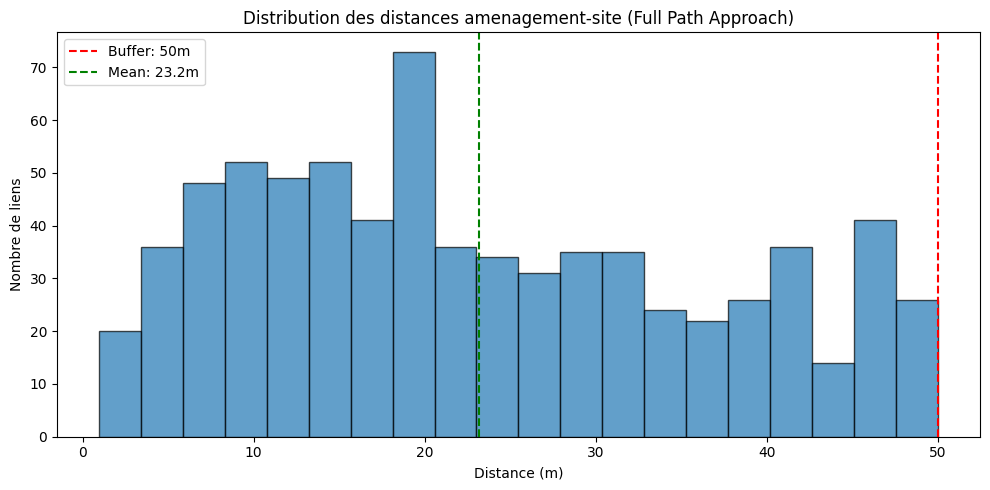

In [13]:
# Distribution des distances
import matplotlib.pyplot as plt

if len(df_links) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df_links['distance_m'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(BUFFER_M, color='red', linestyle='--', label=f'Buffer: {BUFFER_M}m')
    ax.axvline(df_links['distance_m'].mean(), color='green', linestyle='--', label=f'Mean: {df_links["distance_m"].mean():.1f}m')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Nombre de liens')
    ax.set_title('Distribution des distances amenagement-site (Full Path Approach)')
    ax.legend()
    plt.tight_layout()
    plt.show()

## 4. Créer les tables Gold (même format que l'approche précédente)

In [14]:
# Joindre avec les channels (filtrer vélo uniquement)
pdf_channels = df_channels.toPandas()

# Merger links avec channels
df_links_channels = df_links.merge(
    pdf_channels[['site_id', 'channel_id', 'is_bike_channel']],
    on='site_id',
    how='inner'
)

# Filtrer channels vélo uniquement
df_links_channels = df_links_channels[df_links_channels['is_bike_channel'] == True]

print(f"✓ {len(df_links_channels)} liens amenagement-channel (vélo uniquement)")
print(f"✓ {df_links_channels['amenagement_id'].nunique()} aménagements avec channels vélo")

✓ 2250 liens amenagement-channel (vélo uniquement)
✓ 300 aménagements avec channels vélo


In [15]:
# Créer gold_link_amenagement_channel
gold_link_pdf = df_links_channels[['amenagement_id', 'channel_id', 'site_id', 'distance_m']].drop_duplicates()

# Garder 1 seul site par aménagement (le plus proche)
gold_link_pdf = gold_link_pdf.sort_values('distance_m').groupby('amenagement_id').first().reset_index()

print(f"✓ gold_link_amenagement_channel: {len(gold_link_pdf)} rows")
print(f"✓ 1 site par aménagement (le plus proche du tracé)")

gold_link_pdf.head(10)

✓ gold_link_amenagement_channel: 300 rows
✓ 1 site par aménagement (le plus proche du tracé)


,amenagement_id,channel_id,site_id,distance_m
0,100,101030267,100030267,21.747915
1,104,101032824,100032824,5.386156
2,130,353242649,100064524,32.524881
3,1599,102047693,100047693,9.802309
4,1608,100034429,100034429,26.961771
5,1609,100034428,100034428,6.904671
6,1675,353252506,300015200,17.053612
7,168,353500794,300048112,12.041698
8,1696,353500782,300048110,7.306340
9,170,104026959,100026959,1.658892


In [18]:
# SOLUTION: Éviter la conversion Pandas→Spark qui crash sur Windows
# On sauvegarde directement en Parquet avec Pandas, puis on recharge avec Spark

import pyarrow as pa
import pyarrow.parquet as pq

# Préparer le DataFrame final
gold_link_final = gold_link_pdf.copy()
gold_link_final['amenagement_id'] = gold_link_final['amenagement_id'].astype(str)
gold_link_final['channel_id'] = gold_link_final['channel_id'].astype(str)
gold_link_final['site_id'] = gold_link_final['site_id'].astype(str)
gold_link_final['distance_m'] = gold_link_final['distance_m'].astype(float)

# Sauvegarder temporairement avec Pandas/PyArrow
temp_path = f"../../{gold_dir}/gold_link_amenagement_channel_temp"
os.makedirs(temp_path, exist_ok=True)
gold_link_final.to_parquet(f"{temp_path}/part-0.parquet", index=False)

# Recharger avec Spark (évite le problème de sérialisation)
gold_link = spark.read.parquet(temp_path)
gold_link.cache()

print(f"✓ gold_link created: {gold_link.count()} rows")
gold_link.show(10)

✓ gold_link created: 300 rows
+--------------+----------+---------+------------------+
|amenagement_id|channel_id|  site_id|        distance_m|
+--------------+----------+---------+------------------+
|           100| 101030267|100030267| 21.74791522296965|
|           104| 101032824|100032824| 5.386156264617778|
|           130| 353242649|100064524| 32.52488149110728|
|          1599| 102047693|100047693| 9.802308917508464|
|          1608| 100034429|100034429|26.961771148783797|
|          1609| 100034428|100034428| 6.904670798866533|
|          1675| 353252506|300015200|17.053611784241813|
|           168| 353500794|300048112|12.041697835329144|
|          1696| 353500782|300048110| 7.306339888519209|
|           170| 104026959|100026959|1.6588919746449442|
+--------------+----------+---------+------------------+
only showing top 10 rows



In [19]:
# Charger les mesures et joindre avec gold_link
from pyspark.sql.functions import col, sum, countDistinct

# Joindre mesures avec gold_link via site_id
# Note: on assume que df_measures a une colonne site_id ou qu'on peut faire le lien

# Vérifier les colonnes de df_measures
print("Colonnes df_measures:")
print(df_measures.columns)

df_measures.show(5)

Colonnes df_measures:
['point_id', 'point_type', 'flux', 'lat', 'lon', 'direction', 'vehicule_type', 'date']
+---------+----------+----+------------------+------------------+---------+-------------+----------+
| point_id|point_type|flux|               lat|               lon|direction|vehicule_type|      date|
+---------+----------+----+------------------+------------------+---------+-------------+----------+
|100031128|      auto| 726|          45.72373|          4.893222|     NULL|         NULL|2023-02-06|
|100030258|      auto|3763|45.743805467619744|4.8410793877663005|     NULL|         NULL|2023-02-06|
|100031124|      auto| 793|          45.75127|           4.82288|     NULL|         NULL|2023-02-06|
|100047690|      auto|4704| 45.75707455320546| 4.859770542026642|     NULL|         NULL|2023-02-06|
|100052661|      auto| 136|  45.7616829690733|  4.82730039680372|     NULL|         NULL|2023-02-06|
+---------+----------+----+------------------+------------------+---------+--------

In [20]:
# Lier les mesures aux sites via les coordonnées
# On utilise la même logique: chaque mesure est associée au site le plus proche

from pyspark.sql.functions import radians, sin, cos, sqrt, atan2, row_number
from pyspark.sql.window import Window

# Fonction Haversine Spark
def haversine_spark(lat1_col, lon1_col, lat2_col, lon2_col):
    R = 6371000
    lat1_rad = radians(lat1_col)
    lon1_rad = radians(lon1_col)
    lat2_rad = radians(lat2_col)
    lon2_rad = radians(lon2_col)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return lit(R) * c

# Cross join mesures avec sites pour trouver le site le plus proche de chaque mesure
df_measure_site = df_measures.alias("m").crossJoin(
    df_sites.alias("s")
).withColumn(
    "dist_to_site",
    haversine_spark(
        col("m.lat"), col("m.lon"),
        col("s.lat"), col("s.lon")
    )
)

# Garder le site le plus proche pour chaque mesure
window_spec = Window.partitionBy("point_id", "date").orderBy("dist_to_site")

df_measures_with_site = df_measure_site.withColumn(
    "rank", row_number().over(window_spec)
).filter(
    col("rank") == 1
).select(
    col("m.point_id"),
    col("m.date"),
    col("m.flux"),
    col("m.point_type"),
    col("s.site_id")
)

print(f"✓ Linked {df_measures_with_site.count()} measures to nearest sites")

✓ Linked 485651 measures to nearest sites


In [21]:
# Joindre mesures avec gold_link pour obtenir les flux par aménagement
df_flows = gold_link.join(
    df_measures_with_site,
    on="site_id",
    how="inner"
).select(
    "amenagement_id",
    "channel_id",
    "site_id",
    "date",
    "flux",
    "point_id",
    "point_type"
)

print(f"✓ Joined {df_flows.count()} flow records to amenagements")
df_flows.show(10)

✓ Joined 685397 flow records to amenagements
+--------------+----------+---------+----------+----+---------+----------+
|amenagement_id|channel_id|  site_id|      date|flux| point_id|point_type|
+--------------+----------+---------+----------+----+---------+----------+
|          4196| 353480095|100013842|2014-08-06| 763|100013842|      auto|
|          4195| 101013842|100013842|2014-08-06| 763|100013842|      auto|
|          4031| 102013842|100013842|2014-08-06| 763|100013842|      auto|
|          4196| 353480095|100013842|2014-08-09| 590|100013842|      auto|
|          4195| 101013842|100013842|2014-08-09| 590|100013842|      auto|
|          4031| 102013842|100013842|2014-08-09| 590|100013842|      auto|
|          4196| 353480095|100013842|2014-08-10| 686|100013842|      auto|
|          4195| 101013842|100013842|2014-08-10| 686|100013842|      auto|
|          4031| 102013842|100013842|2014-08-10| 686|100013842|      auto|
|          4196| 353480095|100013842|2014-08-17| 994|10

In [22]:
# Agréger par amenagement_id et date
gold_flow_daily = df_flows.groupBy("amenagement_id", "date").agg(
    sum("flux").alias("flux_estime"),
    countDistinct("channel_id").alias("n_channels")
).orderBy("amenagement_id", "date")

gold_flow_daily.cache()

print(f"✓ Created gold_flow_amenagement_daily ({gold_flow_daily.count()} rows)")
gold_flow_daily.show(20)

✓ Created gold_flow_amenagement_daily (685250 rows)
+--------------+----------+-----------+----------+
|amenagement_id|      date|flux_estime|n_channels|
+--------------+----------+-----------+----------+
|           100|2014-01-01|        101|         1|
|           100|2014-01-02|        209|         1|
|           100|2014-01-03|        140|         1|
|           100|2014-01-04|         90|         1|
|           100|2014-01-05|        101|         1|
|           100|2014-01-06|        367|         1|
|           100|2014-01-07|        303|         1|
|           100|2014-01-08|        264|         1|
|           100|2014-01-09|        324|         1|
|           100|2014-01-10|        345|         1|
|           100|2014-01-11|        133|         1|
|           100|2014-01-12|        133|         1|
|           100|2014-01-13|        310|         1|
|           100|2014-01-14|        340|         1|
|           100|2014-01-15|        378|         1|
|           100|2014-01-16|   

## 5. Data Quality Checks

In [23]:
# Check 1: Nombre d'aménagements avec données
amen_with_data = gold_flow_daily.select("amenagement_id").distinct().count()
total_amen = len(pdf_amenagements)

print(f"=== RÉSULTATS FULL PATH APPROACH ===")
print(f"✓ Aménagements avec flux: {amen_with_data} / {total_amen} ({amen_with_data/total_amen*100:.1f}%)")

# Check 2: Pas de flux négatifs
negative_flux = gold_flow_daily.filter(col("flux_estime") < 0).count()
assert negative_flux == 0, "FAILED: Found negative flux values"
print(f"✓ No negative flux values")

# Check 3: n_channels >= 1
zero_channels = gold_flow_daily.filter(col("n_channels") < 1).count()
assert zero_channels == 0, "FAILED: Found days with 0 channels"
print(f"✓ All days have at least 1 channel")

# Check 4: Pas de duplicates
duplicate_check = gold_flow_daily.groupBy("amenagement_id", "date").count().filter(col("count") > 1)
n_duplicates = duplicate_check.count()
assert n_duplicates == 0, f"FAILED: {n_duplicates} duplicates found"
print(f"✓ No duplicate (amenagement_id, date) entries")

print(f"\n🎉 All quality checks passed!")

=== RÉSULTATS FULL PATH APPROACH ===
✓ Aménagements avec flux: 282 / 4592 (6.1%)
✓ No negative flux values
✓ All days have at least 1 channel
✓ No duplicate (amenagement_id, date) entries

🎉 All quality checks passed!


In [24]:
# Summary statistics
summary = gold_flow_daily.groupBy("amenagement_id").agg(
    count("date").alias("total_days"),
    sum("flux_estime").alias("total_flux"),
    avg("flux_estime").alias("avg_daily_flux"),
    spark_max("n_channels").alias("max_channels")
).orderBy(desc("avg_daily_flux"))

print("=== Summary by infrastructure ===")
summary.show(20)

=== Summary by infrastructure ===
+--------------+----------+----------+------------------+------------+
|amenagement_id|total_days|total_flux|    avg_daily_flux|max_channels|
+--------------+----------+----------+------------------+------------+
|          4112|      4266|  28745766| 6738.341772151899|           1|
|          3639|      4266|  28745766| 6738.341772151899|           1|
|          2827|      3567|  22088867| 6192.561536305018|           1|
|          6618|      3567|  22088867| 6192.561536305018|           1|
|          2846|      4120|  22937475| 5567.348300970873|           1|
|          7514|      4120|  22937475| 5567.348300970873|           1|
|           930|       806|   3739698|  4639.82382133995|           1|
|           929|       806|   3739698|  4639.82382133995|           1|
|          3527|      2291|   9255362|4039.8786556089044|           1|
|          4174|      3567|  13833507|3878.1909167367535|           1|
|          2571|      3567|  13833507|3878.

## 6. Save Outputs (Parquet)

In [26]:
# Create output directory
gold_path = f"../../{gold_dir}"
os.makedirs(gold_path, exist_ok=True)

# Save as Parquet (même format que l'approche précédente)
gold_link.write.mode("overwrite").parquet(f"{gold_path}/gold_link_amenagement_channel")
print(f"✓ Saved gold_link_amenagement_channel.parquet")

gold_flow_daily.write.mode("overwrite").parquet(f"{gold_path}/gold_flow_amenagement_daily")
print(f"✓ Saved gold_flow_amenagement_daily.parquet")

print(f"\n✅ All Gold outputs saved to {gold_path}/")

✓ Saved gold_link_amenagement_channel.parquet
✓ Saved gold_flow_amenagement_daily.parquet

✅ All Gold outputs saved to ../../data/gold/


In [27]:
# Verify saved files
print("=== Vérification des fichiers Gold Parquet ===")
for table in ["gold_link_amenagement_channel", "gold_flow_amenagement_daily"]:
    df = spark.read.parquet(f"{gold_path}/{table}")
    print(f"\n{table}: {df.count()} rows, {len(df.columns)} columns")
    df.printSchema()

=== Vérification des fichiers Gold Parquet ===

gold_link_amenagement_channel: 300 rows, 4 columns
root
 |-- amenagement_id: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- distance_m: double (nullable = true)


gold_flow_amenagement_daily: 685250 rows, 4 columns
root
 |-- amenagement_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- flux_estime: long (nullable = true)
 |-- n_channels: long (nullable = true)



## 7. Comparaison avec l'approche centroïde

In [28]:
print("="*60)
print("📊 COMPARAISON: Full Path vs Centroïde")
print("="*60)

print(f"\n🆕 FULL PATH APPROACH (buffer={BUFFER_M}m):")
print(f"   • Aménagements avec données: {amen_with_data}")
print(f"   • Liens amenagement-site: {len(gold_link_pdf)}")
print(f"   • Distance moyenne: {gold_link_pdf['distance_m'].mean():.1f}m")

print(f"\n📌 Avantages de l'approche Full Path:")
print(f"   • Association basée sur le tracé RÉEL, pas le centroïde")
print(f"   • Un compteur à 30m du tracé est détecté même si le centroïde est loin")
print(f"   • Buffer plus restrictif (50m) car plus précis")

print(f"\n✅ Fichiers Gold générés avec le MÊME FORMAT que l'approche précédente")

📊 COMPARAISON: Full Path vs Centroïde

🆕 FULL PATH APPROACH (buffer=50m):
   • Aménagements avec données: 282
   • Liens amenagement-site: 300
   • Distance moyenne: 18.3m

📌 Avantages de l'approche Full Path:
   • Association basée sur le tracé RÉEL, pas le centroïde
   • Un compteur à 30m du tracé est détecté même si le centroïde est loin
   • Buffer plus restrictif (50m) car plus précis

✅ Fichiers Gold générés avec le MÊME FORMAT que l'approche précédente


## 8. Cleanup

In [ ]:
spark.stop()
print("✓ Spark session stopped")